# Partikkel transport med havstrømmer

Dato: 16.04.2024

I dette prosjektet har vi sett på bevegelse av flytende plastikkpartikler i havet. Ved hjelp av data om havstrøm og vind utenfor den norske kysten har vi tatt i bruk Heun's metode som lar oss approksimere banene til partiklene. Dette gjør at vi kan få informasjon over hvor stor andel av plastikken som strandes og når dette skjer. Vi har forsøkt å lage en effektiv kode, slik at kjøretiden blir minimert. For å gjøre dette har vi importert njit fra numba for å kunne kompilere koden.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange, get_num_threads # Njit: No-Python mode, JIT (Just-In-Time compilation)
import time
from tqdm.auto import tqdm, trange # Imported to use progress bars while running code
from scipy.interpolate import RectBivariateSpline
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
%config InlineBackend.figure_formats = ['svg'] # Makes the plots svg (visually better)

#### Heun's metode
Heun's metode er en numerisk teknikk for å løse ordinære differensiallikninger, og den er et forbedret alternativ til den kjente Euler-metoden. Vi vil bruke denne for å approksimere hvordan banen til en partikkel vil se ut. Vi skal starte med interpolatoren f slik den er definert under, men senere vil vi ta i bruk data om vind og havstrøm. I første del av prosjektet har vi implementert `heuns_method()` ved følgende ligninger:

$a(t) = {\epsilon} sin({\omega}t)$ 

$b(t) = 1 - 2{\epsilon}sin({\omega}t)$

$f(x,t) = a(t) x^{2} + b(t) x $

$\dot{x} = [v_{x}(x,t), v_{y}(x,t)]$, der $v_{x} = -{\pi} A sin({\pi} f(x,t))cos({\pi}y)$ og $v_{y} = {\pi} A cos({\pi}f(x,t))sin({\pi}y) \dfrac{\partial f(x,t)}{\partial x}$ 

In [4]:
# Parameters
A = 0.1
epsilon = 0.25
w = 1.0

x_0 = np.array([1.05, 0.5]) # Initial position
h = np.array([0.3, 0.1, 0.05, 0.01, 0.001]) # Different time steps


@njit
def a(t: np.ndarray, epsilon: float, w: float) -> np.ndarray:
    '''
    Given function.

    t: time array
    epsilon: parameter
    w: parameter

    '''
    return epsilon * np.sin(w*t)

@njit
def b(t: np.ndarray, epsilon: float, w: float) -> np.ndarray:
    '''
    Given function.

    t: time array
    epsilon: parameter
    w: parameter

    '''
    return 1 - 2 * epsilon * np.sin(w*t)

@njit
def f(x: float, t: np.ndarray,) -> np.ndarray:
    '''
    Given function.

    x: starting position
    epsilon: parameter
    w: parameter

    '''
    return a(t, epsilon, w) * x**2 + b(t, epsilon, w) * x

@njit
def x_dot1(x_vec: np.ndarray, t: np.ndarray, A: float, epsilon: float, w: float) -> np.stack:
    '''
    Velocity function.

    x_vec: vector of initial positions
    t: time array
    A: parameter
    epsilon: parameter
    w: parameter

    '''
    # x-component of the velocity
    v_x = - np.pi * A * np.sin(np.pi * f(x_vec[:, 0], t)) * np.cos(np.pi * x_vec[:, 1]) 
    # y-component of the velocity
    v_y = np.pi * A * np.cos(np.pi * f(x_vec[:, 0], t)) * np.sin(np.pi * x_vec[:, 1]) * (a(t, epsilon, w) * 2 * x_vec[:, 0] + b(t, epsilon, w)) 
    
    return np.stack((v_x, v_y), axis=1)

@njit
def ceil_div(x, y):
    return -(-x // y)

@njit(parallel=True)
def heuns_method(t: np.ndarray, h: float, epsilon: float, w: float, A: float, x_0_arr: np.ndarray, x_dot: callable) -> tuple[np.ndarray, np.ndarray]:
    '''
    A modified Heun's method for approximating position. 
    Takes in an array of starting posiitons and returns an array of the trajectories. 

    t: time array
    h: step length
    epsilon: parameter
    w: parameter
    A: parameter
    x_0_arr: array of starting positions, 2D array (N, 2)

    '''
    N = x_0_arr.shape[0]
    x_arr = np.empty((len(t), N, 2))
    x_arr[0, :, :] = x_0_arr

    # Calculating the next position t times
    n_threads = get_num_threads()
    chunk_size = ceil_div(N, n_threads)

    for thread in prange(n_threads):
        start = thread * chunk_size
        end = min((thread + 1) * chunk_size, N)
        for ti in range(len(t) - 1):
            k_1s = x_dot(x_arr[ti, start:end], t[ti], A, epsilon, w)
            k_2s = x_dot(x_arr[ti, start:end] + k_1s * h, t[ti] + h, A, epsilon, w)
            x_arr[ti+1, start:end] = x_arr[ti, start:end] + h/2 * (k_1s + k_2s)
    return x_arr

#### Banen til én partikkel

Vi starter med å se på én partikkel fra startposisjon $\mathbf{x}_0 = [1.05, 0.5]$. Vi kalkulerer banen til partikkelen med `heuns_method()` som bruker `x_dot()` som tar i bruk `f()`, som igjen bestemmes av `a()` og `b()`.

Under har vi plottet banen ved ulike tidssteg for tidsintervallene $t ∈ [0, 50]$ og $t ∈ [0, 100]$.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


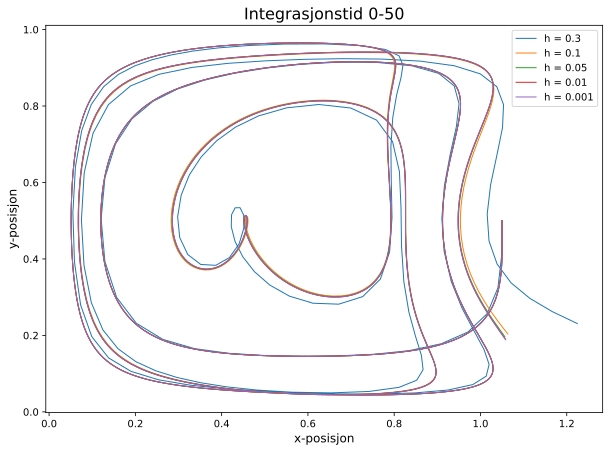

In [5]:
# Plotting for t ∈ [0, 50]
plt.figure(figsize=(10,7))

for i in range(len(h)):
    t = np.arange(0, 50, h[i])
    x, y = heuns_method(t, h[i], epsilon, w, A, x_0[None, :], x_dot1)[:, 0, :].T
    plt.plot(x, y, label=f"h = {h[i]}", lw=1, markersize=4)
plt.xlabel('x-posisjon', fontsize=12)
plt.ylabel('y-posisjon', fontsize=12)
plt.title('Integrasjonstid 0-50', fontsize=16)
plt.legend()

plt.show()

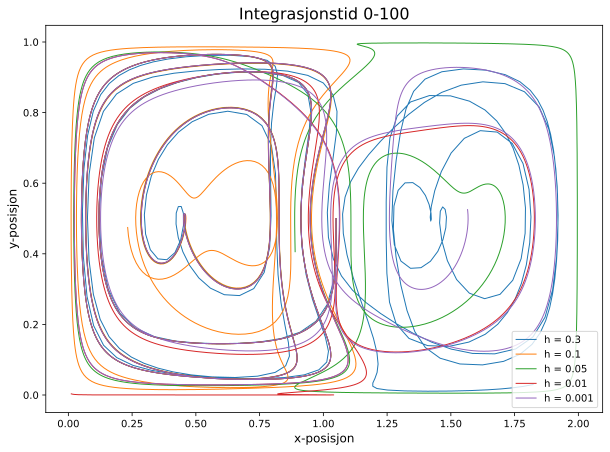

In [6]:
# Plotting for t ∈ [0, 100]
plt.figure(figsize=(10,7))

for i in range(len(h)):
    t = np.arange(0, 100, h[i])
    x, y = heuns_method(t, h[i], epsilon, w, A, x_0[None, :], x_dot1)[:, 0, :].T
    plt.plot(x, y, label=f"h = {h[i]}", lw=1, markersize=4)
plt.xlabel('x-posisjon', fontsize=12)
plt.ylabel('y-posisjon', fontsize=12)
plt.title('Integrasjonstid 0-100', fontsize=16)
plt.legend()

plt.show()

Vi kan se ut ifra plottet med integrasjonstid $t ∈ [0, 50]$ at partikkelen får en tilnærmet lik bane for $h = 0.1$ og $h = 0.01$, dermed kan vi si at et fornuftig kort tidssteg her vil være $h = 0.1$. Imidlertid ser vi at når integrasjonstiden dobbles, altså for $t ∈ [0, 100]$, må vi velge et enda kortere tidssteg. Dette kommer av at løsningen ikke vil være helt nøyaktig, som vises tydeligere jo lenger ut i tidsintervallet vi kommer fordi feilen kumuleres over tid. Vi konkluderer med at $h = 0.01$ kan brukes som tidssteg for å ha en liten feil og samtidig en grei kjøretid for det lengste tidsintervallet.

#### Baner til flere partikler

Vi skal nå se på 100 partikler samtidig, og hvordan de blir påvirket av vektorfeltet. Alle partiklene starter i en rute av størrelse $0.1 \times 0.1$, med $0.01$ i avstand mellom dem. Vi har valgt steglengde $0.1$, da dette gir oss en jevn graf, kontra en høyere steglengde som ville gitt oss en hakkete og ujevn graf.

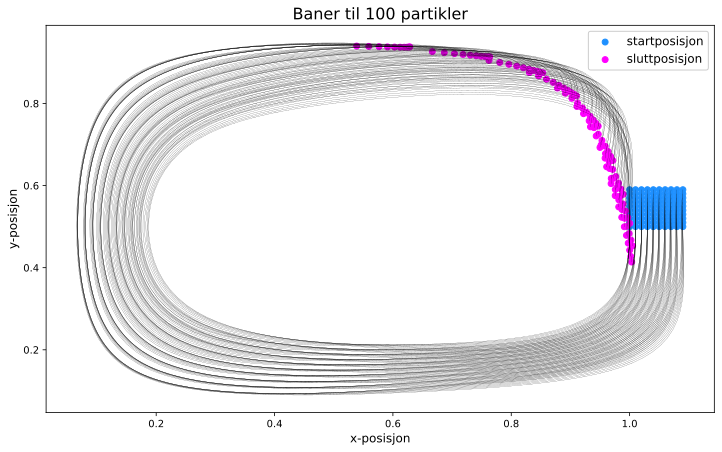

In [7]:
h = 0.1
t = np.arange(0, 10, h)

# Generating 100 initial positions in an 0.1 x 0.1 square
x_0_arr = np.zeros((100, 2))
for i in range(10):
    for j in range(10):
        x_0_arr[i*10 + j] = np.array([1 + i*0.01, 0.5 + j*0.01])

# Using Heun's method
positions = heuns_method(t, h, epsilon, w, A, x_0_arr, x_dot1)

# Plotting
plt.figure(figsize=(12,7))

for i in range(x_0_arr.shape[0]):
    plt.scatter(positions[0, i, 0], positions[0, i, 1], c='dodgerblue') # Initial position
    plt.scatter(positions[-1, i, 0], positions[-1, i, 1], c="magenta") # Final postion
    plt.plot(positions[:, i, 0], positions[:, i, 1], lw=0.15, markersize=4, label=f'Particle {i}', c='black') # Trajectory

plt.title('Baner til 100 partikler', fontsize=16)
plt.xlabel('x-posisjon', fontsize=12)
plt.ylabel('y-posisjon', fontsize=12)
plt.legend(["startposisjon", "sluttposisjon"], framealpha=1, fontsize=12)
plt.show()

Over er start- og sluttposisjon til hver partikkel markert og plot av banen som angir veien mellom dem. Vektorfeltet medfører at partiklene beveger seg i samme tilnærmede sirkulære bane, men grunnet små forskjeller i startsposisjonene vil ikke alle banene overlappe og de varierer i sluttposisjon.

#### Kjøretid

Vi skal videre sjekke at implementasjonen vår er effektiv. I koden har vi gjort flere grep for å oppnå best mulig kjøretid. Vi har unngått å iterere gjennom partiklene, og heller implementert Heun's metode slik at den tar inn en hel array av startposisjoner og itererer gjennom alle på likt. I tillegg har vi brukt njit med `parallel = True`, som gjør at koden blir kjørt på flere prosessorkjerner parallelt.

Under har vi testet kjøretiden på `heuns_method()` for antall partikler fra $10$ til $100\,000$. For å bestemme startposisjonen til et ulikt antall partikler, $N_p$, har vi valgt å implementere en funksjon `position()` som genererer en array av startposisjoner fordelt på et kvadrat. Vi har så laget en for-løkke som måler tiden Heun's metode bruker over ulike $N_p$.

In [10]:
@njit
def position(Np: int, length: float) -> np.ndarray:
    '''
    Generates start positions for Np particles in a square with sidelength 'length'.

    Np: Number of particles
    length: Sidelength of the square with initial positions
    
    '''

    per_side = int(np.sqrt(Np)) # Number of particles in each row and coloum
    spacing = length / per_side # Distance between each inital position
    x_0_arr = np.zeros((per_side**2, 2)) # Defining an array to save the initial positions

    # Adding the initial positions to x_0_array
    for i in range(per_side):
        for j in range(per_side):
            x_0_arr[i * per_side + j] = np.array([(i + 0.5) * spacing, (j + 0.5) * spacing])
            
    return x_0_arr


In [27]:
def plot_runtime(N_p: int, samples: int) -> None:
    '''
    Plots runtime for an intervall from 10 to N_p particles, with a chosen number of samples.
    Inlcudes a linear regression.
    '''
    h = 0.01
    t = np.arange(0, 10, h)
    Np_array = np.geomspace(10, N_p, samples)  # Array of number of particles
    run_time_array = np.zeros(len(Np_array)) # Array of run times

    # Iterating through numbers of particles 
    for i, Np in enumerate(tqdm(Np_array)):
        x_0_arr = position(Np, 1)  # Using sidelength 1
        start_time = time.perf_counter()
        heuns_method(t, h, epsilon, w, A, x_0_arr, x_dot1)
        end_time = time.perf_counter()
        run_time_array[i] = end_time - start_time # Adding the run time to the array

    coefficients = np.polyfit(np.log10(Np_array[len(Np_array) // 2:]), np.log10(run_time_array[len(Np_array) // 2:]), 1) # Finding the coefficients for the linear regression
    linear_fit = np.poly1d(coefficients) # Making linear regression

    plt.figure(figsize=(12,7))

    # Plot of run time
    plt.plot(Np_array, run_time_array, c='dodgerblue', label='Heun, $t ∈ [0, 10]$, h = 0.01')

    # Plot of linear regression
    plt.plot(Np_array, 10.**(linear_fit(np.log10(Np_array))), c='magenta', linestyle='--', label='Linear increase')
    plt.xlabel('Antall partikler', fontsize=12)
    plt.ylabel('Kjøretid [s]', fontsize=12)
    plt.semilogx()
    plt.semilogy()
    plt.grid()
    plt.legend()
    plt.show()

    print(f'Stigning er {np.round(coefficients[0], 2)}')

  0%|          | 0/20 [00:00<?, ?it/s]

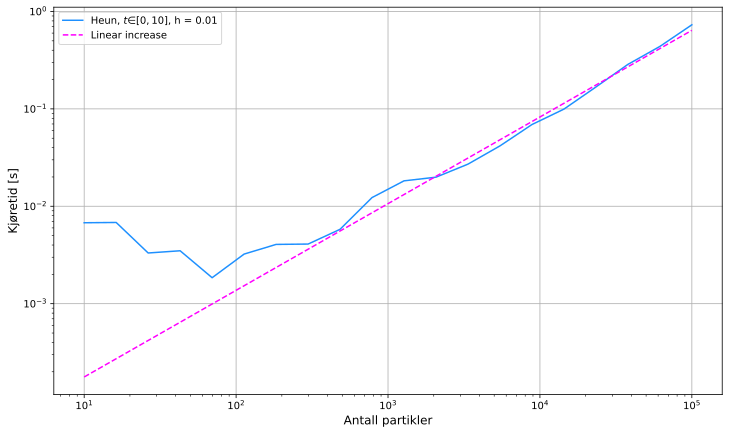

Stigning er 0.89


In [28]:
plot_runtime(100_000, 20)

Her har vi plottet for $N_p = 100\,000$ partikler med 20 steg. Ut i fra plottet observerer vi at kjøretiden er tilnærmet konstant ved $N_p < 10^{3}$, deretter øker den lineært.
Grunnen til at den starter konstant er at ved lave verdier av $N_p$ vil kjøretiden være dominert av overhead.
Dette betyr at mesteparten av kjøretiden går til å kalle på funksjoner, sette opp arrays og å starte tråder.
Her er utregningene såpass små at kjøretiden er nærmest neglesjerbar.
Etterhvert vil utregningene bli større og dominere kjøretiden.
Stigningen til lineærregresjonen er $0.96$, som betyr at kompleksiteten er tilnærmet lineær.
Dette gir mening da forholdet mellom antall partikler og antall utregninger er lineært.
Grunnen til at stigningen er under $1$ er fordi vi har for få partikler slik at kjøretiden fremdeles påvirkes, i mindre grad, av overhead.

  0%|          | 0/20 [00:00<?, ?it/s]

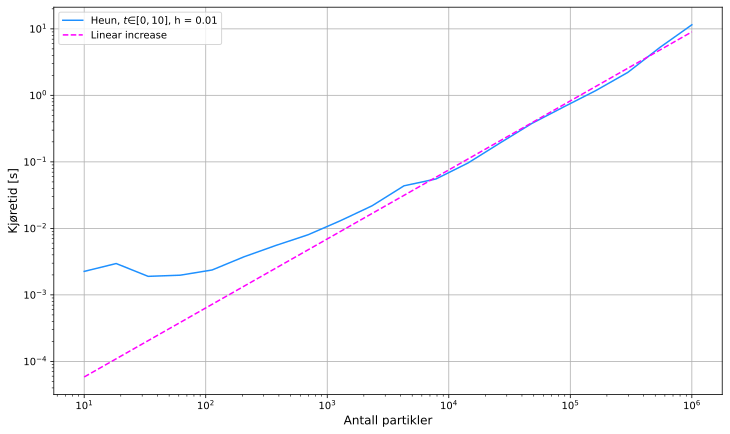

Stigning er 1.04


In [29]:
plot_runtime(1_000_000, 20)

Over har vi plottet samme graf, men nå med $N_p = 1\,000\,000$ partikler og $40$ steg. Vi observerer nå som forventet at stigning er lik $1$ og at grafen er mer lienær enn i forrige plott.

#### Interpolasjon

Klassen Interpolator gir oss tilgang til å bruke data om vind og havstrømmer fra Norges kyst. Den inneholder flere medlemsfunksjoner som vi har brukt i `Heuns()` for å finne en tilnærmede baner til partikler.

In [ ]:
class Interpolator():
    def __init__(self, dataset, fw = 0.03):
        # xarray dataset object
        self.dataset = dataset
        # Windage factor
        self.fw = fw
        # Extract timestamps as number of seconds after the start of the file
        # Saves a bit of bother with dealing with np.datetime objects elsewhere
        self.times = np.array([(t - d.time[0])/np.timedelta64(1, 's') for t in d.time[:]], dtype=np.float64)
        self.depth = np.array(self.dataset.h)
        
    def get_interpolators(self, X, it):
        # Add a buffer of cells around the extent of the particle cloud
        buf  = 10
        # Find extent of particle cloud in terms of indices
        imax = np.searchsorted(self.dataset.X, np.amax(X[0,:])) + buf
        imin = np.searchsorted(self.dataset.X, np.amin(X[0,:])) - buf
        jmax = np.searchsorted(self.dataset.Y, np.amax(X[1,:])) + buf
        jmin = np.searchsorted(self.dataset.Y, np.amin(X[1,:])) - buf
        # Take out subset of array, to pass to
        # interpolation object
        # Fill NaN values (land cells) with 0, otherwise
        # interpolation won't work
        u_current = self.dataset.u[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        v_current = self.dataset.v[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        u_wind    = self.dataset.Uwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        v_wind    = self.dataset.Vwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        # RectBivariateSpline essentially returns a function,
        # which can be called to get value at arbitrary position
        fu_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_current)
        fv_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_current)
        fu_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_wind)
        fv_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_wind)
        return fu_current, fv_current, fu_wind, fv_wind
    
    def get_time_index(self, t):
        # Get index of largest timestamp smaller than (or equal to) t
        return np.searchsorted(self.times, t, side='right') - 1
    
    def on_land(self, X):
        # Find indices for each particle
        ix_list = np.searchsorted(self.dataset.X, X[0,:])
        iy_list = np.searchsorted(self.dataset.Y, X[1,:])
        # Identify which particles are in cells with depth 5
        # (which for some reason is the smallest depth)
        return np.array([self.depth[iy,ix] == 5.0 for ix, iy in zip(ix_list, iy_list)])

    def __call__(self, X, t):
        # get index of current time in dataset
        it = self.get_time_index(t)
        # get interpolating functions,
        # covering the extent of the particle
        fu_current, fv_current, fu_wind, fv_wind = self.get_interpolators(X, it)
        # Evaluate velocity at position(x[:], y[:])
        dx = fu_current(X[0,:], X[1,:], grid = False) + self.fw*fu_wind(X[0,:], X[1,:], grid = False)
        dy = fv_current(X[0,:], X[1,:], grid = False) + self.fw*fv_wind(X[0,:], X[1,:], grid = False)
        return np.array([dx, dy])

Under har vi definert en ny Heuns funksjon, denne tar også inn et element av datatypen Interpolator. I Interpolator klassen brukes vindfaktor, som er med på å bestemme hvor mye vinden interagerer med partiklene. I første del brukes default value $f_{w} = 0.03$, senere skal vi se på andre verdier. Ved å sende inn et 2D-array med startposisjonene til partiklene får vi ut et 3D-array med posisjonen til hver partikkel for hver time. Dette har vi brukt til å plotte banen til partiklene inkludert start og sluttposisjon. Vi har valgt å bruke $N_p=1000$, da vi mener dette er nok partikler til å forstå mønsteret til partikkelbanene uten at kjøretiden blir lang. For å kunne se banene i plottet med relativt mange partikler har vi brukt svake, tynne, svarte linjer.

In [ ]:
d = xr.open_dataset('./NorKyst-800m.nc')
f = Interpolator(dataset = d)
N_p = 1000
X = np.zeros((2, N_p))

# Generating Gaussian random x and y positions for the X array
X[0,:] = np.random.normal(loc = 790_000., scale=10_000., size = N_p)
X[1,:] = np.random.normal(loc = 490_000., scale=10_000., size = N_p)

# Setting total time to 5 days (seconds)
t = 432_000 

def Heuns(X: np.ndarray, Np: int, f: Interpolator, h: int, t: int, disable_pbar=False) -> np.ndarray:
    '''
    Heun's method.
    Used for approximating trajectories.

    X: array of initial positions
    Np: number of particles
    f: Interpolator
    h: time step
    t: total time in seconds
    
    '''

    t_arr = np.arange(0., t, h)
    x_arr = np.zeros((2, Np, len(t_arr)))
    x_arr[:, :, 0] = X  # Initializing the first time step

    # Iterating through each time step
    irange = trange(len(t_arr) - 1) if not disable_pbar else range(len(t_arr) - 1)
    for i in irange:
        # Calculating the derivative at the current time step
        k_1 = f(x_arr[:, :, i], t_arr[i])
        # Estimating the derivative at the next time step
        k_2 = f(x_arr[:, :, i] + k_1 * h, t_arr[i] + h)
        # Updating the next position
        x_arr[:, :, i + 1] = x_arr[:, :, i] + h / 2 * (k_1 + k_2)

    # Returning the array containing the poition at each time step
    return x_arr

X_arr = Heuns(X, N_p, f, 3600.0, t)

In [ ]:
plt.figure(figsize=(12, 7))

# Plotting all trajectories with start and end posistions
for i in range(N_p):
    plt.plot(X_arr[0, i], X_arr[1, i], alpha=0.05, c='black')
    plt.scatter(X_arr[0, i, 0], X_arr[1, i, 0], s=9, c='dodgerblue', label='Start posisjon' if i ==0 else None)
    plt.scatter(X_arr[0, i, -1], X_arr[1, i, -1], s=9, c='magenta', label='Slutt posisjon' if i == 0 else None)

plt.title('Transport av partikler på 5 dager', fontsize=16)
plt.xlabel('x-posisjon', fontsize=12)
plt.ylabel('y-posisjon', fontsize=12)
plt.legend()
plt.grid()
plt.show()

#### Plotting på kart
Videre har vi brukt den utdelte koden til å plotte banen til partiklene på et kart. Vi valgte å lage en funksjon, `plotting_on_map()`, som plotter på kartet. Dette er for å spare oss for repeterende kodelinjer når vi skal plotte for ulike steder.

In [ ]:
def plotting_on_map(N_p: int, X_arr: np.ndarray, title: str, map_position: tuple[float, float, float, float]) -> None:
    '''
    Plots trajectories on a map including marking of start and end positions.

    N_p: Number of particles
    X_arr: Trajectories of the particles
    title: Title on the plot
    map_position: tuple with coordinates 
    
    '''
    plt.figure(figsize=(10,7))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())

    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#cccccc'))

    # Create projection object for converting particle positions
    npstere = ccrs.Stereographic(
        central_latitude = 90,
        central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
        false_easting = f.dataset.projection_stere.false_easting,
        false_northing = f.dataset.projection_stere.false_northing,
        true_scale_latitude = f.dataset.projection_stere.standard_parallel,
    )

    legend_added = False

    for i in trange(N_p):
        # Checks if legend is added
        if not legend_added:
            ax.plot(X_arr[0, i], X_arr[1, i], alpha=0.05, transform=npstere, c='black', label='Partikkelbane')
            ax.scatter(X_arr[0, i, 0], X_arr[1, i, 0], transform=npstere, s=10, c='dodgerblue', label='Startpunkt')
            ax.scatter(X_arr[0, i, -1], X_arr[1, i, -1], transform=npstere, s=10, c='magenta', label='Sluttpunkt')
            legend_added = True
        else:
            ax.plot(X_arr[0, i], X_arr[1, i], alpha=0.05, transform=npstere, c='black')
            ax.scatter(X_arr[0, i, 0], X_arr[1, i, 0], transform=npstere, s=10, c='dodgerblue')
            ax.scatter(X_arr[0, i, -1], X_arr[1, i, -1], transform=npstere, s=10, c='magenta')
    # Set outline
    ax.set_extent(map_position)
    # Add gridlines
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )
    ax.set_title(title, fontsize=16)
    ax.legend()
    plt.tight_layout()

Under har vi plottet samme partikkelbaner som over, men nå på et kart. De normalfordelte startsposisjonene tilsvarer et sted litt utenfor Trondheim, så vi har valgt koordinater slik at kartet dekker partikkelbanene.

In [ ]:
# Making the plot for outside Trondheim
title = 'Utenfor Trondheim'
map_position = (7.0, 11.0, 63.8, 65.3)

plotting_on_map(N_p, X_arr, title, map_position)

Vi kan se på kartet at partiklene vil bevege seg i ulike retninger. Noen vil returnere tilbake til startposisjonen, mens andre beveger seg nordover. Dette kan komme av forskjeller i startposisjonene og påvirkning fra vind og havstrømmer. Likevel kan vi se at noen av partiklene følger en nokså lik bane.

Videre har vi generert nye startposisjoner utenfor to andre store byer i Norge. Vi brukte Figur $1$ og $2$ fra oppgavebeskrivelsen til å velge forventningsverdi til Gaussfordelingene. I tillegg har vi endret på koordinatene til kartet for at det skal dekke partikkelbanene. Plottingen skjer ved samme funksjon som tidligere, men med nye parametere. Under kan man se hvordan $N_p=500$ partikler med normalfordelte startposisjoner ville beveget seg utenfor Bergen.

In [ ]:
# Making a plot outside Bergen
N_p = 500
X = np.zeros((2, N_p))
X[0,:] = np.random.normal(loc = 330_000., scale=10_000., size = N_p) # Gaussian random x-vals
X[1,:] = np.random.normal(loc = 548_000., scale=10_000., size = N_p) # Gaussian random y-vals
t = 432_000 # 5 days

X_arr = Heuns(X, N_p, f, 3600.0, t)
title = 'Utenfor Bergen'
map_position = (1.0, 8.0, 60.0, 62.6)

plotting_on_map(N_p, X_arr, title, map_position)

Som vi kan se på kartet vil vinden og havstrømmene sammen gjøre at alle partiklene beveger seg nordover. 

Under har vi, på samme måte som for Trondheim og Bergen, plottet hvordan $N_p=500$ partikler beveger seg utenfor Tromsø.

In [ ]:
# Making a plot outside Tromsø
N_p = 500
X = np.zeros((2, N_p))
X[0,:] = np.random.normal(loc = 1550_000., scale=10_000., size = N_p) # Gaussian random x-vals
X[1,:] = np.random.normal(loc = 548_000., scale=10_000., size = N_p) # Gaussian random y-vals
t = 432000 # 5 days

X_arr = Heuns(X, N_p, f, 3600.0, t)
title = 'Utenfor Tromsø'
map_position = (10.0, 22.0, 69.0, 71.0)

plotting_on_map(N_p, X_arr, title, map_position)

Igjen kan vi se at partiklene vil bevege seg i lignende baner, der de blir påvirket i ulik grad av vind og havstrømmer. Dette resulterer i at partiklene beveger seg noe vekk fra fastlandet og sørover.

#### Stranding av plastikk
Vi skal nå se på hvor lang tid det tar før plastikkpartiklene strander på land. Vi har derfor implementert plastics_pos() som tar hensyn til at når partiklene treffer land stopper de opp. Dette gir oss en oversikt over hvor lang tid det tar, og hvor stor andel av partiklene som strander. I praksis gir dette oss informasjon om hvor søppel i havet ender opp. Vi kan da se hvor eventuell opprydding vil være nødvendig.

Vi har laget en ny funksjon `plotting_with_stranding()` som tar hensyn til om partiklene er strandet eller ikke. Fargen på sluttposisjonen gjør det enkelt å skille de partiklene som strandes fra de på sjøen.

In [ ]:
t = 259_200 # 3 days
h = 3600.0
hours = int(t/h)

def plastics_pos(X_arr: np.ndarray, on_land_arr: np.ndarray, N_p: int) -> tuple[np.ndarray, float, np.ndarray]:
    '''
    Calculates end positions of particles and percentage of stranded particles. Also returns a time array for when stranding takes place.
    '''
    end_pos = np.zeros((2, N_p))
    stranded = 0
    hours_arr = np.zeros(N_p)

    for i in range(N_p):
        hour = 0
        # Counting up the hours until the particle strands or the time runs out
        while (hour < hours and on_land_arr[i][hour] == False):
            hour += 1
        end_pos[0][i] = X_arr[0][i][hour-1]
        end_pos[1][i] = X_arr[1][i][hour-1]

        # If the particle reaches land before the end of the simulation, update stranded count
        if (hour < hours):
            stranded += 1
        hours_arr[i] = hour

    # Calculating the percentage of particles that are stranded
    percentage = (stranded/N_p) * 100

    return end_pos, percentage, hours_arr

def plotting_with_stranding(N_p: int, X: np.ndarray, title: str, map_position: tuple[float, float, float, float]) -> None:
    ''' 
    Plots trajectories on a map including start and end positions, wrt the particles being stranded or not.

    N_p: Number of particles
    X: Initial positions
    title: title of the plot
    map_position: tuple of the coordinates
    '''
    # Calculate particle positions using Heun's method
    X_arr = Heuns(X, N_p, f, h, t)

    # Determine if particles are on land
    on_land_arr = f.on_land(X_arr)

    # Calculate end positions and percentage of particles stranded
    end_pos, percentage, hours_arr = plastics_pos(X_arr, on_land_arr, N_p)
    print(f'Prosentandel strandet: {np.round(percentage)}')

    plt.figure(figsize=(10,7))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())

    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#cccccc'))

    # Create projection object for converting particle positions
    npstere = ccrs.Stereographic(
        central_latitude = 90,
        central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
        false_easting = f.dataset.projection_stere.false_easting,
        false_northing = f.dataset.projection_stere.false_northing,
        true_scale_latitude = f.dataset.projection_stere.standard_parallel,
    )

    # Plot particle trajectories with start and end positions
    k = 0
    j = 0
    for i in trange(N_p):
        ax.scatter(X_arr[0, i, 0], X_arr[1, i, 0], transform=npstere, s=2, c='dodgerblue', label='Start posisjon' if i ==0 else None)
        if (hours_arr[i] < hours):
            ax.scatter(end_pos[0, i], end_pos[1, i], transform=npstere, s=2, c ='blueviolet', zorder=4, label='Strandet' if j == 0 else None)
            array_x = X_arr[0, i, :int(hours_arr[i])]
            array_y = X_arr[1, i, :int(hours_arr[i])]
            j += 1
            ax.plot(array_x, array_y, alpha=0.03, transform=npstere, c='black', zorder=1)
        else:
            ax.scatter(end_pos[0, i], end_pos[1, i], transform=npstere, s=2, c ='fuchsia', zorder=3, label='På sjøen' if k == 0  else None)
            ax.plot(X_arr[0, i], X_arr[1, i], alpha=0.03, transform=npstere, c='black', zorder=2)
            k += 1

    # Set extent and add gridlines
    ax.set_extent(map_position)
    ax.set_title(title, fontsize=16)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )
    plt.legend()
    ax.legend()
    plt.tight_layout()

In [ ]:
map_position = (2.0, 8.0, 59.0, 62.0)
# Generating random particle positions
N_p = 500
X = np.zeros((2, N_p))
X[0,:] = np.random.normal(loc = 250_000., scale=10_000., size = N_p)
X[1,:] = np.random.normal(loc = 460_000., scale=10_000., size = N_p)

plotting_with_stranding(N_p, X, 'Utenfor Stavanger', map_position)

Over har vi sett på hvordan vind og havstrømmer påvirker plastikkpartikler utenfor Stavanger. Vi observerer at omtrent halvparten av partiklene strandes. Ved $N_p = 500$ ser vi tydelig hvordan partiklene beveger seg, samtidig som kjøretiden ikke blir betydlig lang.

In [ ]:
map_position = (10.0, 12.0, 59.0, 60.0)
# Generating random particle positions
N_p = 500
X = np.zeros((2, N_p))
X[0,:] = np.random.normal(loc = 370_000., scale=1400., size = N_p)
X[1,:] = np.random.normal(loc = 116_000., scale=1500., size = N_p)

plotting_with_stranding(N_p, X, 'Oslofjorden', map_position)

For å se hvordan vind og havstrømmer varierer langs den norske kysten ser vi nærmere på Oslofjorden. Dette er en smal fjord, og vi ser tydelig på kartet hvordan partiklene snirkler seg innover mot Oslo. På grunn av havstrømmene og den trange fjorden strander nesten alle partiklene. Dette kan være noe av grunnen til at det er mer forrurenset i Oslofjorden enn utenfor Stavanger. For å plotte disse partiklene på kartet har vi satt ned standardavviket til normalfordelingen for at alle initalposisjonene skal være ved starten av fjorden.

Vi skal nå se nærmere på prosentandel strandede partikler over 3 døgn.

In [ ]:
plt.figure(figsize=(12,7))

map_position = (2.0, 8.0, 59.0, 62.0)

# Generating random particle positions
N_p = 500
X = np.zeros((2, N_p))
X[0,:] = np.random.normal(loc = 250_000., scale=10_000., size = N_p)
X[1,:] = np.random.normal(loc = 460_000., scale=10_000., size = N_p)
X_arr = Heuns(X, N_p, f, h, t)

def percentage(X_arr: np.ndarray, hours: int) -> tuple[np.ndarray, np.ndarray]:
    ''' 
    Takes in trajectories for particles and hours and returning an time array and an array of the percentage of stranded particles

    X_arr: trajectories
    hours: time

    '''

    time_arr = np.arange(hours)
    percentage_arr = np.zeros(hours)
    on_land_arr = f.on_land(X_arr)
    hours_arr = plastics_pos(X_arr, on_land_arr, N_p)[2] # When the particles strand

    for i in range(hours):
        stranded = 0
        for j in range(len(hours_arr)):
            # Check if the particle was stranded before, or at the current hour
            if hours_arr[j] < i:
                stranded += 1
        # Calculate the percentage of stranded particles for the current hour
        percentage_arr[i] = (stranded/N_p)*100
    return time_arr, percentage_arr

time_arr, percentage_arr = percentage(X_arr, hours)

plt.plot(time_arr, percentage_arr)
plt.title('Stavanger', fontsize=16)
plt.xlabel('Tid [timer]', fontsize=12)
plt.ylabel('Prosentandel strandede partikler', fontsize=12)
plt.grid()
plt.show()

Vi ser at det tar rundt 60 timer før de første partiklene treffer land. Deretter er det eksponensiell vekst, noe som gir mening fordi partiklene starter i samme område. Grafen påvirkes av hvor  vi befinner oss langs norskekysten, vi har derfor plottet en tilsvarende graf for Oslofjorden.

In [ ]:
# Oslo
plt.figure(figsize=(12,7))

map_position1 = (10, 12, 59, 60)
# Generating random particle positions

X1 = np.zeros((2, N_p))
X1[0,:] = np.random.normal(loc = 370_000., scale=1400., size = N_p)
X1[1,:] = np.random.normal(loc = 116_000., scale=1500., size = N_p)
X_arr1 = Heuns(X1, N_p, f, h, t)


time_arr1, percentage_arr1 = percentage(X_arr1, hours)

plt.plot(time_arr1, percentage_arr1)
plt.title('Oslofjorden', fontsize=16)
plt.xlabel('Tid [timer]', fontsize=12)
plt.ylabel('Prosentandel strandede partikler', fontsize=12)
plt.grid()
plt.show()

Trappeformen på grafen indikerer at partiklene strandes i grupper, noe som kommer av den snirklete fjorden.

#### Vindfaktorens påvirkning på stranding av partikler
Vi skal nå se på hvordan vindfaktoren påvirker resultatene. Vindfaktoren beskriver i hvilken grad et flytende objekt blir påvirket av vind og havstrøm. En lav vindfaktor vil påvirke plastikkpartikler lite, altså vil det være lite forflyttelse blant partiklene. Dersom vindfaktoren er høy vil vinden ha lettere for å rive med seg partikler. Dermed vil flere plastpartikler strandes ved høyere vindfaktor når vinden har retning mot land. For å sjekke teorien vår har vi laget et array med 20 vindfaktorer fra $0$ til $0.15$ og plottet prosentandel strandede partikler som funksjone av vindfaktor etter 3 døgn.

In [ ]:
fw_arr = np.linspace(0, 0.15, 20) # Array of windage factors

def stranded_per_fw(fw_arr: np.ndarray) -> np.ndarray:
    ''' 
    Takes in an array of windage factors and returns an array with percentage of stranded particles.
    '''
    stranded_per_fw = np.zeros(len(fw_arr)) # Empty array to save the values

    # Iterating through all windage factors
    for i in trange(len(fw_arr)):
        f_i = Interpolator(dataset = d, fw=fw_arr[i])
        X_arr = Heuns(X, N_p, f_i, h, t, disable_pbar=True)
        on_land_arr = f.on_land(X_arr)
        stranded_per_fw[i] = plastics_pos(X_arr, on_land_arr, N_p)[1]
    return stranded_per_fw

plt.figure(figsize=(12,7))
plt.plot(fw_arr, stranded_per_fw(fw_arr))
plt.title('Stavanger', fontsize=16)
plt.xlabel('Vindfaktor', fontsize=12)
plt.ylabel('Antall strandede partikler', fontsize=12)
plt.grid()
plt.show()

Grafen har form som en sigmoid kurve. Ved lav vindfaktor er det få partikler som strander, noe som stemmer med teorien vår. Etterhvert øker antall strandede partikler vesentlig før den stabiliserer seg på 100%. Dette gir mening siden vinden utenfor Stavanger går inn mot land, så jo større vindfaktoren er jo mer plastikk vil vinden dra med seg, som resulterer i mer strandet plastikk.

Denne grafen ville sett ulik ut om vi hadde endret tidspunktet vi sjekker antall strandede partikler på. Derfor har vi i tillegg plottet prosentandel strandede partikler som funksjon av tid, for ulike vindfaktorer, i samme plott under.

In [ ]:
fig = plt.figure(figsize=(12,7))
hours = 72

fw_arr = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06])
time_arr = np.arange(hours)

# Plotting the percentage of stranded particles as a function of time and with different windage factors
for i in trange(len(fw_arr)):
    f_i = Interpolator(dataset = d, fw=fw_arr[i])
    X_arr = Heuns(X, N_p, f_i, h, t, disable_pbar=True)
    time_arr, percentage_arr = percentage(X_arr, hours)
    plt.plot(time_arr, percentage_arr, label = 'f_w = ' + str(fw_arr[i]))
    
plt.title('Stavanger', fontsize=16)
plt.xlabel('Tid [timer]', fontsize=12)
plt.ylabel('Prosentandel strandede partikler', fontsize=12)
plt.legend()
plt.grid()
plt.show()

Som vi kan se over vil prosentandelen strandede plastpartikler øke ved høyere vindfaktor og etter lenger tid. Er vindfaktoren lik 0, vil det ikke strande noen partikler uansett hvor mange timer det går. Om vindfaktoren er høyere, derimot, tar det fortsatt en del timer før partiklene strander, men andelen strandede etter 3 døgn øker. Det er viktig å huske at plottet her kun gjelder for utenfor Stavanger. Hadde vi valgt et annet sted, hvor vinden går ut fra land, ville ikke en høy vindfaktor ført til at flere partikler strandet.

I løpet av dette prosjektet har vi sett hvor mye informasjon vi kan tilegne oss om den virkelige verden ved hjelp av numeriske metoder i Python. Vi har brukt Heun's metode for å approksimere hvordan plastpartikler vil bevege seg utenfor den norske kysten. Videre har vi sett på hvordan vindfaktor og tid har påvirket resultatene. Programmet vårt kan brukes i praksis til å forutsi plastikkumuleringssoner som kan hjelpe miljøet vårt på flere måter enn én. En potensiell situasjon kan være en fiskebåt som mister noe av utstyret sitt midt på havet. Da kan ressurser effektivt allokeres til å rydde opp på de riktige stedene. Et annet viktig aspekt er bevaring av dyrelivet i havet. Slik kan dette være nøkkelen til å beskytte sjødyrene mot farene ved menneskelig plastforurensning.

Referanseliste:
